# Strain rates comparison Tutorial

In this tutorial we will walk through how to understand various methods for calculating strain rate and how they are similar and different. 
Strain rate is related to the spatial derivatives of velocity, just as strain is related to the spatial derivatives of displacements: 
$$ \epsilon_{ij} = 0.5 (\partial \dot{u}_y/\partial x + \partial \dot{u}_x / \partial y) $$

In this tutorial we will compare strain rates for several methods and calculate various statistics of interest. 

## Interpolation models

The methods in Strain_2D used to calculate strain rate mostly (all except Delaunay) involve some type of interpolation. 
Interpolation introduces uncertainty, since the surface velocities are not known everywhere. 
Different methods have different approaches to handle this uncertainty; however, each method has to define a way to handle the three fundamental characteristics of an interpolation scheme: 
1. The degree of fit to the data (except for certain approaches which use the data exactly as is; this is not ideal as the data have errors that get propagated through to the strain rate). 
2. The degree of smoothness; or the behavior of the interpolated field at very short length scales. E.g. a surface can be continuous but not differentiable, or it could be both continuous and differentiable. 
3. The spatial correlation length scale - a distance scale the describes the characteristic length over which measurements are correlated. The assumption is that once you get far enough away from a point, the data no longer helps you to interpolate the value at that point. 

These three fundamental properties of any interpolation scheme can be visualized using correlation plots as shown below

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
# Setup some formatting and plot commands
SMALL_SIZE = 7
MEDIUM_SIZE = 10
BIGGER_SIZE = 11

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def plotCov(h, *args, **kwargs):
    f = plt.figure(figsize=(4, 2.5), dpi=300)
    for k, arg in enumerate(args):
        if np.mod(k, 2) == 0:
            plot_sym = '-'
        elif np.mod(k, 3) == 0:
            plot_sym = '-.'
        else:
            plot_sym = '--'
        if 'namelist' in kwargs.keys():
            plt.plot(h, arg, plot_sym, label=kwargs['namelist'][k])
        else:
            plt.plot(h, arg, plot_sym)
    plt.ylim([-0.1, np.max(np.max([arg for arg in args])) + 0.1])
    plt.xlim([0, 10])
    plt.legend()
    plt.axhline(y=0, linestyle='--', c='k', linewidth=0.5)
    plt.xlabel('Distance')
    plt.ylabel('Covariance')

White noise is a special type of model which can be added to any of the other models. 

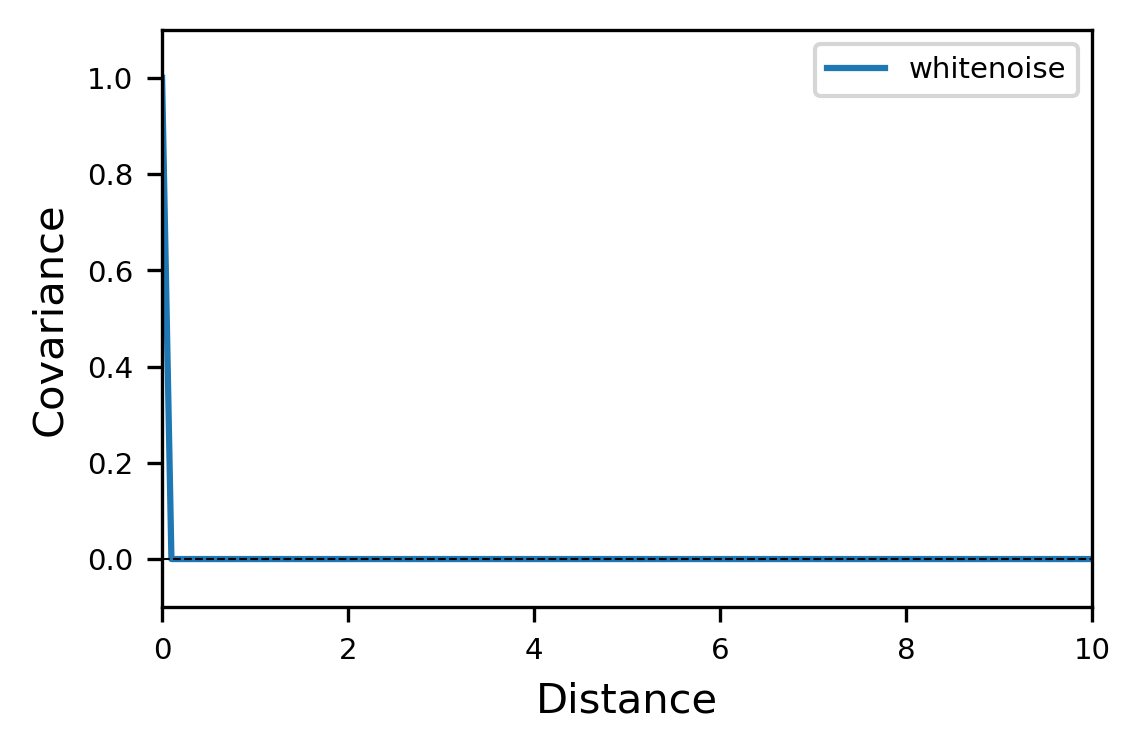

In [4]:
# distance
h = np.linspace(0, 20, 200)

# various covariance functions


# A white noise or "nugget" model. Points are always perfectly correlated to themselves, otherwise the correlation is zero
# The nugget is the variance of the white-noise process
def whiteNoise(h, nugget):
    out = np.zeros(h.shape)
    out[h == 0] = nugget
    return out


plotCov(h, whiteNoise(h, 1), namelist=['whitenoise'])

We can model the various interpolation methods as having a particular correlation length scale (range), total variance (sill), and point-wise variance (nugget). 

In addition, different models behave differently at short and long distances. 
In the next section, note the differences between models and what distance scale is required to reach zero correlation. 
Also note how the curves approach the y-intercept, either at a high angle or flat. 

In [4]:
# A Gaussian model, described by a variance scale (sill), correlation length (range), and the data noise (nugget)
# VISR and geostats can both use Gaussian covariance models to calculate weights
def Gaussian(h, sill, range, nugget=None):
    out = sill * np.exp(-0.5 * np.square(h / range))
    return [out + nugget * (h == 0) if nugget is not None else out][0]

In [5]:
# An Exponential model, with the same parameters as a Gaussian but a different behavior at short distances
# geostats can use an Exponential covariance model to calculate weights
def Exponential(h, sill, range, nugget=None):
    out = sill * np.exp(-0.5 * (h / range))
    return [out + nugget * (h == 0) if nugget is not None else out][0]

In [6]:
# VISR has the option to use a quadratic function to calculate weights
def quadratic(h, sill, range, nugget=None):
    denom = 1 + np.square(h / range)
    return (sill / denom) + nugget * (h == 0)

In [7]:
# if you can have a quadratic you can have a linear! Not currently used by any of the Strain_2D methods but one could implement one
# this is 1/r, or Inverse-distance weighting
def linear(h, sill, range, nugget=None):
    output = sill - (sill / range) * h
    output[output < 0] = 0.0
    return output + nugget * (h == 0)

In [8]:
# Local average gradient (LAG) uses a boxcar-like window function
# Note that this is *NOT* going to work as a covariance matrix, because it will in general not be positive semidefinite
def boxcar(h, sill, range, nugget=None):
    return sill * (h < range) + nugget * (h == 0)

In [9]:
# GPSgridder uses Green's functions for point (body) forces in an elastic thin plate to interpolate. The basic solution is ln(r)
def thin_plate(h, sill, range, nugget=None):
    return sill - (1 / range) * np.log(h + 1)

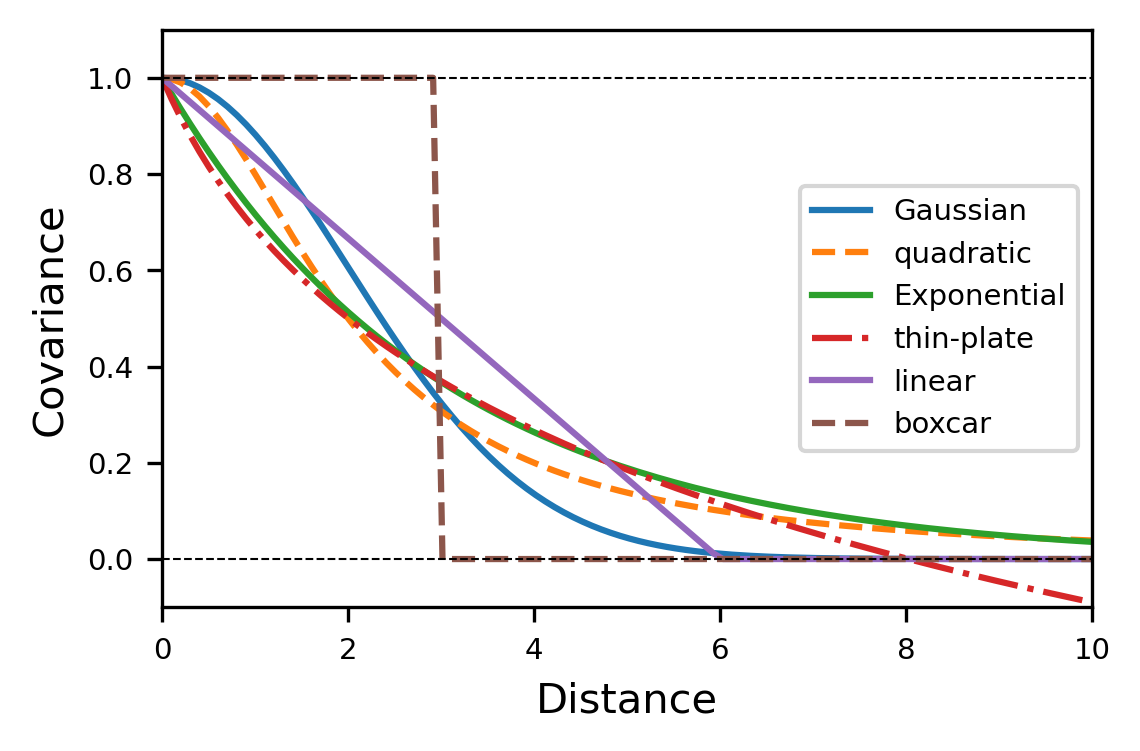

In [10]:
# We can compare multiple models
# Note that even when the effective length scales are similar, the behavior is different due to the different models
# plotCov(
#     h,
#     Gaussian(h, 1, 2, 0),
#     Exponential(h, 1, 1.5, 0),
#     quadratic(h, 1, 2, 0),
#     # linear(h, 1, 6, 0),
#     # boxcar(h, 1, 3, 0),
#     namelist=['Gaussian', 'Exponential', 'quadratic',],
# )
plotCov(
    h,
    # Gaussian and quadratic models have a similar short-distance behavior while Gaussian decays faster at long distances
    Gaussian(h, 1, 2, 0),
    quadratic(h, 1, 2, 0),
    # Exponential and thin-plate models behave similarly at short distances but diverage at long distances
    # The thin-plate model is not positive semi-definite
    Exponential(h, 1, 1.5, 0),
    thin_plate(h, 1, 2.2, 0),
    # Linear and boxcar models can be thought of as simple approximations to a gradually decaying curve
    linear(h, 1, 6, 0),
    boxcar(h, 1, 3, 0),
    namelist=['Gaussian', 'quadratic', 'Exponential', 'thin-plate', 'linear', 'boxcar'],
)

plt.axhline(y=1, linestyle='--', c='k', linewidth=0.5)

From the plot above, we can see that each model behaves slightly differently yet has similarities. One possible exception is the thin-plate model, which does not decay with distance, but this is not a problem as long as only the area inside the area containing data is considered; extrapolation would be unstable with this function. 

## Data inputs

Strain_2D takes a space-delimited file in a specific format. The format is shown below: 

In [5]:
# The text file header uses the hash mark for reading in awk, so we will pass the names explicitly
import pandas as pd


df = pd.read_csv(
    'data/Guatemala_gnss_ITRF08_Strain2DFormat.txt',
    delim_whitespace=True,
    skiprows=1,
    names=['Lon', 'Lat', 'VE', 'VN', 'VU', 'SE', 'SN', 'SU', 'ID'],
)

In [6]:
# The provided example dataset for northern california
df.head()

,Lon,Lat,VE,VN,VU,SE,SN,SU,ID
0,-89.833,13.575,-0.2,8.8,0.0,-0.4,-0.4,100,ACAJ
1,-89.683,13.836,3.8,8.1,0.0,-2.4,-1.4,100,AGLA
2,-89.808,13.909,-0.8,7.2,0.0,-0.6,-0.6,100,AHUA
3,-89.050,13.447,0.9,8.4,0.0,-0.5,-0.6,100,AIES
4,-87.999,13.405,6.8,7.2,0.0,-2.5,-1.8,100,AMAT


The velocity components get interpolated separately except in the case of _gpsgridder_, which allows for explicit coupling between the components. Other methods may have indirect coupling when using the same interpolation parameters for both components. 

<AxesSubplot: xlabel='Lon', ylabel='Lat'>

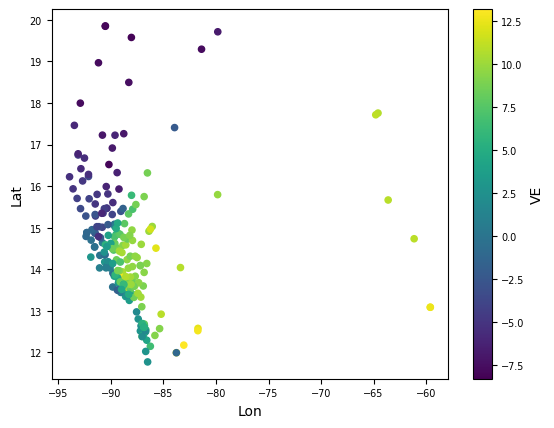

In [7]:
# plot the easting velocities
df.plot.scatter(x='Lon', y='Lat', c='VE')

<AxesSubplot: xlabel='Lon', ylabel='Lat'>

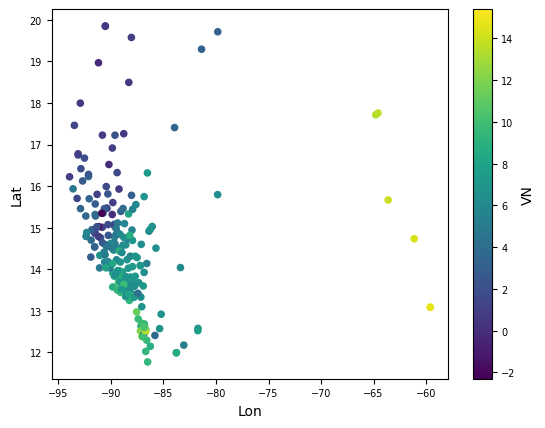

In [27]:
# Plot the northing velocities
df.plot.scatter(x='Lon', y='Lat', c='VN')

## Configuration file
The configuration file has a standard format shown below: 
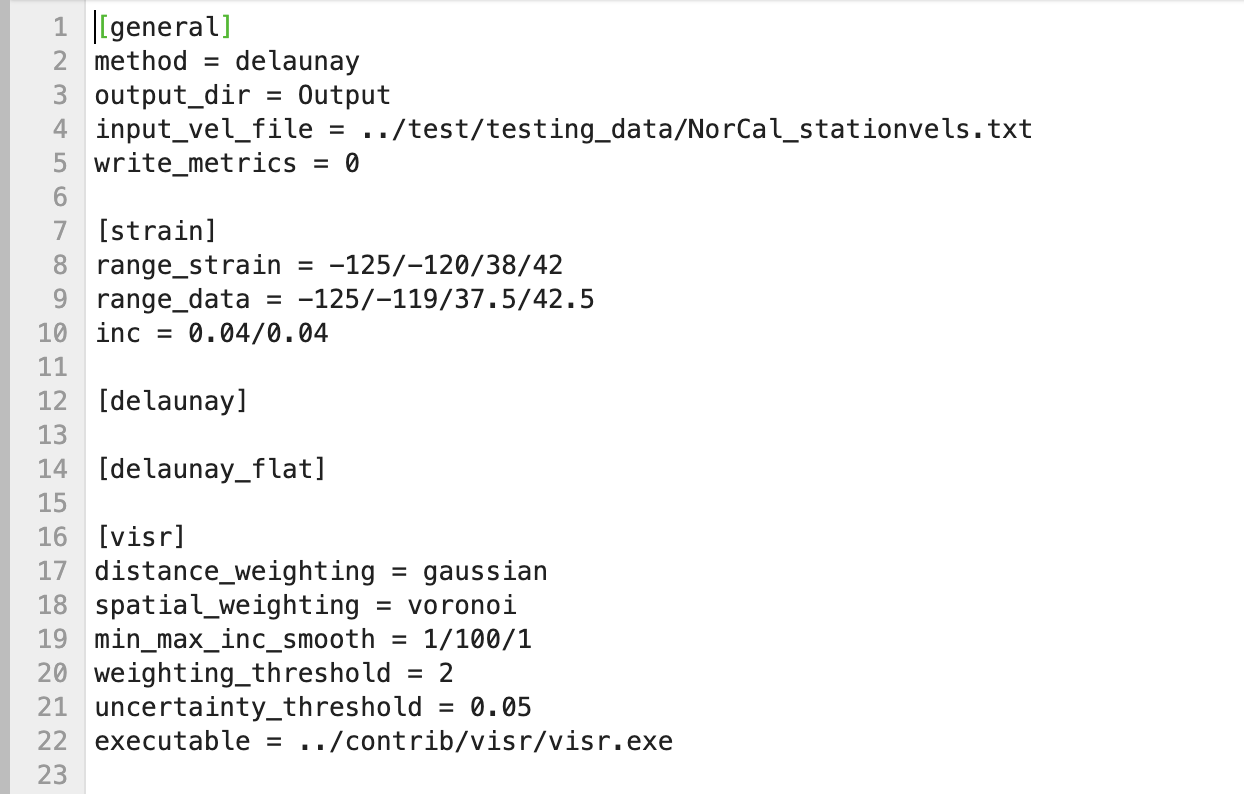

General runtime parameters are at the top, followed by the parameters required by each method. 
Only the method listed after "method = " in the general configuration will be run. 
When a particular method gets called, the code will look at the configuration options given in the list under that methods' header (in square brackets). 

Currently supported methods include delaunay, delaunay_flat, visr, gpsgridder, loc_avg_grad, wavelets, geostats, and strain_comparison. 

## Running the code

Running the --help command will print out example usage and the currently available modules

In [8]:
!strain_rate_compute.py --help

  Welcome to a geodetic strain-rate calculator.

  USAGE 1: strain_rate_compute.py config.txt      <-- for running a strain calculation
  USAGE 2: strain_rate_compute.py --help          <-- for printing help message
  USAGE 3: strain_rate_compute.py --print_config  <-- for writing example config file

Available modules are:
  delaunay
  delaunay_flat
  geostats
  gpsgridder
  loc_avg_grad
  wavelets
  visr
 


In [9]:
!strain_rate_compute.py --print_config # to print out an example configuration file in the current directory

Writing example config file.
Writing file example_strain_config.txt 


In order to calculate strain rates, make sure that the "range_strain" and "range_data" are set to the proper bounding boxes (WESN format). 
Data outside of "range_data" will be ignored when calculating strain rate. 
Strain rates will only be calculated for the "range_strain" bounding box. 

For this example we will use the example data set that is available in the test folder. 
We have provided three example files which will run the _gpsgridder_, _local average gradient_, and _geostats_ methods. 

**Note**: You will need to change the example configuration file that gets generated for this example. 
- First, change the data file to "./data/Guatemala_gnss_ITRF08_Strain2DFormat.txt" 
- change the "write_metrics" parameter to "1" in order to get data misfit and total moment calculated
- change the "method" to "gpsgridder"

In [11]:
# Once the configuration file is properly defined, running the code is as simple as:
!strain_rate_compute.py data/example_strain_config.txt


------------------------------
Hello! We are...
   Computing strain using : gpsgridder 
   Input data from        : ./data/Guatemala_gnss_ITRF08_Strain2DFormat.txt
   Calculation range      : [-93.0, -87.0, 13.0, 17.0]
   Putting the outputs    : Output/gpsgridder/ 

------------------------------
Reading file ./data/Guatemala_gnss_ITRF08_Strain2DFormat.txt 
217 stations before applying cleaning.
195 stations after imposing bounding box.

------------------------------
Computing strain via gpsgridder method.
writing vector output file tempgps.txt 
gmt gpsgridder tempgps.txt -R-93.05/-86.95/12.95/17.05 -I0.1/0.1 -S0.5 -Fd0.01 -C0.0005 -Emisfitfile.txt -fg -r -Gnc_%s.nc
gpsgridder [ERROR]: Data constraint 133 and 132 occupy the same location but differ in observation (-2/-2.5 vs 1.5/-0.5)
gpsgridder [ERROR]: Data constraint 173 and 172 occupy the same location but differ in observation (8.9/9.6 vs 7/7.1)
gpsgridder [WARNING]: Found 2 data constraint duplicates with different observation

Outputs from Strain_2D are stored in the "Output" folder, which can be changed in the config file. 

In [12]:
# A bunch of files and images get generated by Strain_2D
!ls Output/gpsgridder

I2nd.png                  max_shear.png             obs_vels.txt
azimuth.png               misfitfile.txt            positive_eigs.txt
dilatation.png            mycpt.cpt                 residual_vels.txt
example_strain_config.txt nc_u.nc                   rotation.png
gpsgridder_strain.nc      nc_v.nc                   strain_metrics.txt
landmask.grd              negative_eigs.txt


In [13]:
# You can also look at strain_metrics.txt for some summary metrics if metrics=1 is in your config
# Note that delaunay has no misfit! It fits the data exactly
with open('Output/gpsgridder/strain_metrics.txt') as f:
    for line in f.readlines():
        print(line.strip())

Mu: 30.000000 GPa
Depth: 11.000000 km
Infile: Output/gpsgridder/gpsgridder_strain.nc
Moment rate accumulation: 3.824467 e18 N-m / year

Median absolute deviation: 0.69527 mm/yr
Median chi2: 0.43884


In [32]:
# You can get all the data generated by Strain_2D in the netcdf file generated
ds = xr.load_dataset('Output/gpsgridder/gpsgridder_strain.nc')
print(ds)

<xarray.Dataset>
Dimensions:     (y: 41, x: 61)
Coordinates:
  * x           (x) float64 -93.0 -92.9 -92.8 -92.7 ... -87.3 -87.2 -87.1 -87.0
  * y           (y) float64 13.0 13.1 13.2 13.3 13.4 ... 16.7 16.8 16.9 17.0
Data variables:
    Ve          (y, x) float32 -3.546 -3.371 -3.196 -3.02 ... 2.657 2.958 3.255
    Vn          (y, x) float32 7.299 7.294 7.286 7.274 ... 2.239 2.364 2.486
    exx         (y, x) float32 15.74 15.75 15.78 15.85 ... 27.34 26.94 26.75
    eyy         (y, x) float32 -15.16 -15.26 -15.41 ... -24.06 -24.15 -24.32
    exy         (y, x) float32 -1.149 -1.214 -1.364 ... -4.247 -4.446 -4.572
    azimuth     (y, x) float64 2.127 2.24 2.499 2.747 ... 4.692 4.936 5.075
    rotation    (y, x) float32 0.7276 0.6407 0.4895 0.3551 ... 15.49 15.56 15.6
    I2          (y, x) float32 -119.9 -120.9 -122.5 ... -337.9 -335.2 -335.7
    dilatation  (y, x) float32 0.5829 0.4891 0.3714 0.2323 ... 3.278 2.783 2.421
    max_shear   (y, x) float32 15.49 15.55 15.66 15.81 ... 26.05

### Plots
Let's look at some of the plots generated by Strain_2D. 
Plots are found in `Output/<method name>`

Dilatation rate:
[Dilation_rate](./Output/gpsgridder/dilatation.png)

Max shear strain rate:
[Max shear strain rate](./Output/gpsgridder/max_shear.png)


Visit www.github.com/kmaterna/Strain_2D for more examples of how to run Strain_2D. 

In [15]:
def mo2mw(Mo):
    return (2 / 3) * np.log10(Mo * 1e7) - 10.7

In [16]:
mo2mw(3.824467e18)

6.355047278598629